In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [23]:
df_prestige_og = pd.read_csv('../AMM/data/institution-stats.csv')
df_prestige_math = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Mathematics'].copy()
df_prestige_msor = df_prestige_og[(df_prestige_og['TaxonomyValue'] == 'Mathematics') |(df_prestige_og['TaxonomyValue'] == 'Statistics') | (df_prestige_og['TaxonomyValue'] == 'Operations Reseach')].copy()
df_prestige_stats = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Statistics'].copy()
df_prestige_or = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Operations Research'].copy()

df_edgesog = pd.read_csv('../AMM/data/edge-lists.csv')
df_math_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Mathematics'].copy()
df_math_stats_or_edges = df_edgesog[(df_edgesog['TaxonomyValue'] == 'Mathematics') |(df_edgesog['TaxonomyValue'] == 'Statistics') | (df_edgesog['TaxonomyValue'] == 'Operations Reseach')].copy()
df_stats_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Statistics'].copy()
df_or_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Operations Research'].copy()

def OverallInstitutionCount(df):
    df_data_by_institution = pd.concat([df.groupby('InstitutionName')['Men'].sum(), df.groupby('InstitutionName')['Women'].sum()],axis=1)
    df_data_by_institution['Percentage of Women'] = df_data_by_institution['Women']/(df_data_by_institution['Men']+df_data_by_institution['Women'])*100
    return df_data_by_institution.reset_index()

fields = ['Mathematics', 'Statistics', 'Operations Research']
combined_df = dict()
for field in fields:
    combined_df[field] = OverallInstitutionCount(df_edgesog[df_edgesog['TaxonomyValue'] == field].copy()).merge(df_prestige_og[df_prestige_og['TaxonomyValue'] == field].copy(),on='InstitutionName')
    combined_df[field] = combined_df[field].sort_values(by=['OrdinalPrestigeRank']).reset_index(drop=True)
    combined_df[field] = combined_df[field].reset_index().rename(columns={'index' : 'Rescaled Rank' })

combined_df['Mathematics']

elite_df = dict()
non_elite_df = dict()
for field in fields:
    elite_df[field] = combined_df[field][combined_df[field]['Rescaled Rank'] < np.quantile(combined_df[field]['Rescaled Rank'],.25)]
    non_elite_df[field] = combined_df[field][combined_df[field]['Rescaled Rank'] >= np.quantile(combined_df[field]['Rescaled Rank'],.25)]


In [24]:
file_encoding = 'utf8'        # set file_encoding to the file encoding (utf8, latin1, etc.)
input_fd = open("data/DUE_awards.csv", encoding=file_encoding, errors = 'backslashreplace')
nsf_df = pd.read_csv(input_fd)
nsf_df['AwardedAmountToDate'] = nsf_df['AwardedAmountToDate'].apply(lambda x: x.replace('$','').replace(',','').replace('.00','')).astype(int)
print("The total amount awarded by NSF per year was $" + str(int(round(nsf_df['AwardedAmountToDate'].sum()/10,-6)/1000000))+"M")
#Quick check for duplicate award numbers
print(nsf_df['AwardNumber'].duplicated().value_counts())

nsf_institution = nsf_df.groupby('Organization')['AwardedAmountToDate'].sum()
#nsf_institution.sort_values(ascending=False)
nsf_frame = nsf_institution.to_frame().reset_index()
merged_df = combined_df['Mathematics'].merge(nsf_institution.to_frame(), left_on = 'InstitutionName',right_on='Organization',how='left')

#This merge didn't go great since the dataset and the NSF have variance in institution names...
print(np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']).size)
print(np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']))

#Produce file names.txt with data set institution names
with open("intermediate files/names.txt", "w") as txt_file:
    for line in np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']):
        txt_file.write(line + "\n")

#Produce NSF_namees.txt with NSF institution names
array=nsf_frame['Organization'].astype(str).sort_values().values
with open("intermediate files/NSF_names.txt", "w") as txt_file:
    for line in array:
        txt_file.write(line + "\n")

The total amount awarded by NSF per year was $324M
AwardNumber
False    5187
Name: count, dtype: int64
123
['Air Force Institute of Technology' 'Arizona State' 'Auburn' 'Baylor'
 'Boston University' 'Bowling Green State' 'Brandeis' 'Brown' 'CU Boulder'
 'CU Denver' 'Caltech' 'Carnegie Mellon' 'Case Western Reserve'
 'Central Michigan' 'Clarkson' 'Clemson' 'Colorado State' 'Columbia'
 'Cornell' 'Dartmouth' 'Duke' 'Emory' 'Florida State' 'George Washington'
 'Georgia State' 'Georgia Tech' 'Harvard' 'Howard' 'Illinois State'
 'Indiana University Bloomington' 'Iowa State' 'Johns Hopkins'
 'Kansas State' 'Kent State' 'LSU' 'Lehigh' 'Louisiana Tech'
 'Loyola University Chicago' 'MIT' 'Marquette' 'Michigan State'
 'Mississippi State' 'Missouri S&T' 'Montana State' 'NYU'
 'New Mexico State' 'North Carolina State' 'Northeastern'
 'Northern Illinois' 'Northwestern' 'Oklahoma State' 'Old Dominion'
 'Oregon State' 'Penn State' 'Portland State' 'Princeton' 'Purdue' 'Rice'
 'Rutgers - New Brunswick'

Text(0, 0.5, 'NSF DUE Average Annual Funds Awarded in Millions')

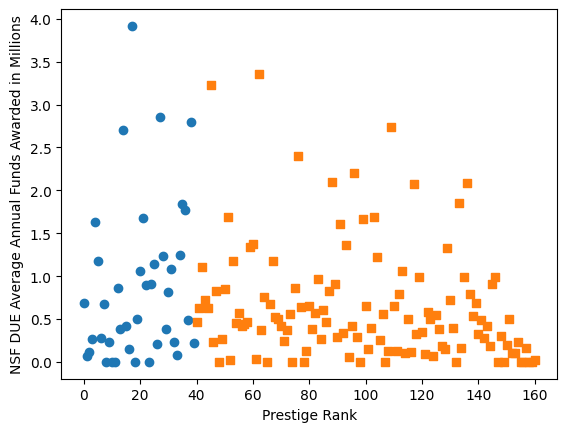

In [36]:
name_map = pd.read_csv("intermediate files/Insitution Names.csv")
#name_map
merged_df2 = merged_df.merge(name_map, left_on = 'InstitutionName',right_on='Wapman name',how='left')
merged_df3 = merged_df2.merge(nsf_institution,left_on= 'NSF name', right_on = 'Organization',how='left')
merged_df3['AwardedAmount']=merged_df3['AwardedAmountToDate_x'].fillna(0)+merged_df3['AwardedAmountToDate_y'].fillna(0)
df_merged_final = merged_df3[['InstitutionName','Percentage of Women','Rescaled Rank','AwardedAmount','Men','Women']]

elite = df_merged_final[df_merged_final['Rescaled Rank'] < np.quantile(df_merged_final['Rescaled Rank'],.25)]
non_elite = df_merged_final[df_merged_final['Rescaled Rank'] >= np.quantile(df_merged_final['Rescaled Rank'],.25)]
plt.scatter(elite['Rescaled Rank'], elite["AwardedAmount"]/10000000)
plt.scatter(non_elite['Rescaled Rank'], non_elite["AwardedAmount"]/10000000,marker='s')
plt.xlabel('Prestige Rank')
plt.ylabel('NSF DUE Average Annual Funds Awarded in Millions')

In [37]:
print("Elite institutions amassed $" + str(int(round(elite['AwardedAmount'].sum()/10,-6)/1000000)) + "M of NSF money per year")
print("Non-Elite institutions, of which there are three times as many, were awarded $" + str(int(round(non_elite['AwardedAmount'].sum()/10,-6)/1000000)) + "M of NSF money per year")

Elite institutions amassed $35M of NSF money per year
Non-Elite institutions, of which there are three times as many, were awarded $78M of NSF money per year


In [47]:
df_merged_final.sort_values(by=['AwardedAmount'],ascending=False).head(10)

,InstitutionName,Percentage of Women,Rescaled Rank,AwardedAmount,Men,Women
17,University of Wisconsin-Madison,14.285714,17,39172430.0,42.0,7.0
62,CU Boulder,17.647059,62,33619071.0,42.0,9.0
45,Michigan State,16.949153,45,32257438.0,49.0,10.0
27,Penn State,13.333333,27,28515449.0,52.0,8.0
38,Purdue,15.942029,38,27941380.0,58.0,11.0
109,Arizona State,26.168224,109,27430493.0,79.0,28.0
14,University of Michigan,18.461538,14,27070328.0,53.0,12.0
76,University of Nebraska-Lincoln,25.581395,76,24001581.0,32.0,11.0
96,North Carolina State,20.338983,96,22023453.0,47.0,12.0
88,Virginia Tech,19.565217,88,20943351.0,37.0,9.0


In [38]:
nsf_df = nsf_df.groupby('Organization')['AwardedAmountToDate'].sum().to_frame().reset_index()
nsf_df

,Organization,AwardedAmountToDate
0,Montana Technological University,597181
1,"ACE Mentor Program of America, Inc.",25000
2,ARMSTRONG STATE UNIVERSITY,329334
3,"AUGUSTA UNIVERSITY RESEARCH INSTITUTE, INC.",905444
4,Adams State University,510021
...,...,...
1297,Yale University,2840555
1298,Yavapai College,1055348
1299,Yosemite Community College District,1103175
1300,Youngstown State University,999971


In [39]:
nsf_df.sort_values(by='AwardedAmountToDate', ascending=False).head(20)

,Organization,AwardedAmountToDate
1204,University of Wisconsin-Madison,39172430
1089,University of Colorado at Boulder,33619071
610,Michigan State University,32257438
766,Pennsylvania State Univ University Park,28515449
788,Purdue University,27941380
50,Arizona State University,27430493
807,Regents of the University of Michigan - Ann Arbor,27070328
827,Rochester Institute of Tech,25185368
1140,University of Nebraska-Lincoln,24001581
24,American Association for the Advancement of Sc...,22903335


In [40]:
nsf_df.sort_values(by='AwardedAmountToDate', ascending=False).tail(20)

,Organization,AwardedAmountToDate
391,Franklin and Marshall College,38982
569,Luther College,36690
28,American Chemical Society (ACS),35650
432,Hamline University,33737
1094,University of Connecticut Health Center,32808
669,National Collegiate Inventors and Innovators A...,29945
38,American Psychological Assoc,29100
543,Lehigh University,27001
526,Lake Superior State University,26158
194,Centralia College,25000


In [41]:
print(gini(nsf_df['AwardedAmountToDate'].values))


0.6313838807995312


In [42]:
print(gini(df_merged_final['AwardedAmount'].values))


0.5288541781414117
